<a href="https://colab.research.google.com/github/Felixphz/Proyecto-Modelos/blob/main/99%20-%20modelo%20soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extrayendo Información desde Kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

 79% 16.0M/20.1M [00:00<00:00, 78.7MB/s]
100% 20.1M/20.1M [00:00<00:00, 75.6MB/s]


In [ ]:
!unzip udea*.zip > /dev/null
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  50135751 test.csv
   692501  10666231 118025055 train.csv
  1286075  15528571 172877479 total


# Importaciones e Instalaciones necesarias.

In [ ]:
!pip install catboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Clase para la generación del modelo

La clase **StudentPerformanceClassifier** está diseñada para predecir el rendimiento académico de los estudiantes a partir de diversos datos demográficos y socioeconómicos. Utiliza el modelo de clasificación **CatBoostClassifier** para realizar las predicciones. La clase implementa un proceso completo de preprocesamiento de datos, que incluye la creación de características a partir de la educación de los padres, el estrato socioeconómico, la matrícula universitaria y otros factores relacionados con los programas académicos y los departamentos de los estudiantes. Además, la clase incluye técnicas de codificación dirigida (target encoding) para mejorar la representación de categorías en las variables. El modelo entrenado se evalúa a través de métricas de clasificación, como el reporte de clasificación y la matriz de confusión, y proporciona una visualización de la importancia de las características utilizadas en el modelo.

In [ ]:
class StudentPerformanceClassifier:
  """
    Clasificador de rendimiento académico utilizando CatBoost.
    Esta clase implementa un modelo de clasificación multiclase para predecir el rendimiento
    académico de estudiantes basado en características socioeconómicas y académicas.
  """
    def __init__(self):
        self.model = None
        self.feature_importance = None
        self.target_encodings = {}
        self.df_train = None

    def rendimiento_to_numeric(self, rendimiento):
        """
        Convierte las categorías de rendimiento a valores numéricos
        """
        mapping = {
            'bajo': 0,
            'medio-bajo': 1,
            'medio-alto': 2,
            'alto': 3
        }
        return mapping[rendimiento]

    def create_location_program_features(self, df, target_df=None):
        """
        Generamos características basadas en la ubicación y programa académico del estudiante.

        Esta función realiza target encoding sobre los programas académicos y departamentos,
        calculando estadísticas como la media, desviación estándar y conteo de estudiantes.

            DataFrame con las nuevas características agregadas:
            - PROG_RENDIMIENTO_MEDIO: Rendimiento promedio por programa
            - PROG_RENDIMIENTO_STD: Desviación estándar del rendimiento por programa
            - PROG_COUNT: Cantidad de estudiantes por programa
            - DEPT_RENDIMIENTO_MEDIO: Rendimiento promedio por departamento
            - DEPT_RENDIMIENTO_STD: Desviación estándar del rendimiento por departamento
            - DEPT_COUNT: Cantidad de estudiantes por departamento
        """

        if target_df is not None:
            # Convertir rendimiento a numérico para el encoding
            target_df = target_df.copy()
            target_df['RENDIMIENTO_NUM'] = target_df['RENDIMIENTO_GLOBAL'].map(self.rendimiento_to_numeric)

            # Target encoding para programa académico
            prog_stats = target_df.groupby('ESTU_PRGM_ACADEMICO')['RENDIMIENTO_NUM'].agg(['mean', 'std']).reset_index()
            self.target_encodings['programa'] = prog_stats.set_index('ESTU_PRGM_ACADEMICO')

            # Target encoding para departamento
            dept_stats = target_df.groupby('ESTU_PRGM_DEPARTAMENTO')['RENDIMIENTO_NUM'].agg(['mean', 'std']).reset_index()
            self.target_encodings['departamento'] = dept_stats.set_index('ESTU_PRGM_DEPARTAMENTO')

            # Agregar conteos
            prog_counts = target_df.groupby('ESTU_PRGM_ACADEMICO').size()
            dept_counts = target_df.groupby('ESTU_PRGM_DEPARTAMENTO').size()
            self.target_encodings['programa']['count'] = prog_counts
            self.target_encodings['departamento']['count'] = dept_counts

        # Aplicar target encoding
        df['PROG_RENDIMIENTO_MEDIO'] = df['ESTU_PRGM_ACADEMICO'].map(self.target_encodings['programa']['mean'])
        df['PROG_RENDIMIENTO_STD'] = df['ESTU_PRGM_ACADEMICO'].map(self.target_encodings['programa']['std'])
        df['PROG_COUNT'] = df['ESTU_PRGM_ACADEMICO'].map(self.target_encodings['programa']['count'])

        df['DEPT_RENDIMIENTO_MEDIO'] = df['ESTU_PRGM_DEPARTAMENTO'].map(self.target_encodings['departamento']['mean'])
        df['DEPT_RENDIMIENTO_STD'] = df['ESTU_PRGM_DEPARTAMENTO'].map(self.target_encodings['departamento']['std'])
        df['DEPT_COUNT'] = df['ESTU_PRGM_DEPARTAMENTO'].map(self.target_encodings['departamento']['count'])

        return df

    def create_education_features(self, df):
        """
        Generamos características basadas en el nivel educativo de los padres del estudiante.

        Esta función convierte los niveles educativos a valores numéricos y crea características
        derivadas que representan la situación educativa familiar.

            DataFrame con las nuevas características agregadas:
            - FAMI_EDUCACIONPADRE_NUM: Nivel educativo del padre (numérico)
            - FAMI_EDUCACIONMADRE_NUM: Nivel educativo de la madre (numérico)
            - FAMI_EDUCACION_PROMEDIO: Promedio educativo de ambos padres
            - FAMI_EDUCACION_DIFERENCIA: Diferencia absoluta entre niveles educativos
            - FAMI_EDUCACION_MAX: Máximo nivel educativo entre los padres
            - FAMI_EDUCACION_MIN: Mínimo nivel educativo entre los padres
        """
        education_mapping = {
            'Ninguno': 0,
            'Primaria incompleta': 1,
            'Primaria completa': 2,
            'Secundaria (Bachillerato) incompleta': 3,
            'Secundaria (Bachillerato) completa': 4,
            'Técnica o tecnológica incompleta': 5,
            'Técnica o tecnológica completa': 6,
            'Educación profesional incompleta': 7,
            'Educación profesional completa': 8,
            'Postgrado': 9,
            'No sabe': 4,
            'No Aplica': 4,
            'No reporta': 4
        }

        df['FAMI_EDUCACIONPADRE_NUM'] = df['FAMI_EDUCACIONPADRE'].map(education_mapping)
        df['FAMI_EDUCACIONMADRE_NUM'] = df['FAMI_EDUCACIONMADRE'].map(education_mapping)

        #Generar nuevas features

        df['FAMI_EDUCACION_PROMEDIO'] = (df['FAMI_EDUCACIONPADRE_NUM'] + df['FAMI_EDUCACIONMADRE_NUM']) / 2
        df['FAMI_EDUCACION_DIFERENCIA'] = abs(df['FAMI_EDUCACIONPADRE_NUM'] - df['FAMI_EDUCACIONMADRE_NUM'])
        df['FAMI_EDUCACION_MAX'] = df[['FAMI_EDUCACIONPADRE_NUM', 'FAMI_EDUCACIONMADRE_NUM']].max(axis=1)
        df['FAMI_EDUCACION_MIN'] = df[['FAMI_EDUCACIONPADRE_NUM', 'FAMI_EDUCACIONMADRE_NUM']].min(axis=1)

        return df

    def create_economic_features(self, df):
        """
        Generamos características basadas en la condición económica del estudiante.

        Esta función convierte variables categóricas económicas a valores numéricos y
        crea un score socioeconómico ponderado basado en estrato, matrícula e internet.

            DataFrame con las nuevas características agregadas:
            - FAMI_ESTRATO_NUM: Estrato socioeconómico (numérico)
            - MATRICULA_NUM: Valor de matrícula (numérico)
            - INTERNET_BIN: Indicador binario de acceso a internet
            - SCORE_SOCIOECONOMICO: Puntuación ponderada de condición económica
        """
        estrato_mapping = {
            'Estrato 1': 1,
            'Estrato 2': 2,
            'Estrato 3': 3,
            'Estrato 4': 4,
            'Estrato 5': 5,
            'Estrato 6': 6,
            'Sin Estrato': 0,
            'No reporta': 3
        }

        matricula_mapping = {
            'Menos de 500 mil': 0,
            'Entre 500 mil y menos de 1 millón': 1,
            'Entre 1 millón y menos de 2.5 millones': 2,
            'Entre 2.5 millones y menos de 4 millones': 3,
            'Entre 4 millones y menos de 5.5 millones': 4,
            'Entre 5.5 millones y menos de 7 millones': 5,
            'Más de 7 millones': 6,
            'No pagó matrícula': 0,
            'No reporta': 3
        }

        df['FAMI_ESTRATO_NUM'] = df['FAMI_ESTRATOVIVIENDA'].map(estrato_mapping)
        df['MATRICULA_NUM'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].map(matricula_mapping)
        df['INTERNET_BIN'] = (df['FAMI_TIENEINTERNET'] == 'Si').astype(int)

        # Generar nueva feature
        df['SCORE_SOCIOECONOMICO'] = (
            df['FAMI_ESTRATO_NUM'] * 0.4 +
            df['MATRICULA_NUM'] * 0.4 +
            df['INTERNET_BIN'] * 0.2
        )

        return df

    def preprocess_data(self, data):
        """
        Preprocesamos los datos incluyendo feature engineering donde generamos nuevas features y target encoding
        """
        X = data.copy()
        y = X.pop('RENDIMIENTO_GLOBAL')

        categorical_features = {
            'ESTU_VALORMATRICULAUNIVERSIDAD': 'No reporta',
            'ESTU_HORASSEMANATRABAJA': 'No reporta',
            'FAMI_ESTRATOVIVIENDA': 'No reporta',
            'FAMI_TIENEINTERNET': 'No reporta',
            'FAMI_EDUCACIONPADRE': 'No reporta',
            'FAMI_EDUCACIONMADRE': 'No reporta',
            'ESTU_PAGOMATRICULAPROPIO': 'No reporta'
        }

        #Rellenar nan

        for col, fill_value in categorical_features.items():
            X[col] = X[col].fillna(fill_value)

        X = self.create_education_features(X)
        X = self.create_economic_features(X)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Target encoding
        train_with_target = pd.concat([X_train, pd.Series(y_train, name='RENDIMIENTO_GLOBAL')], axis=1)
        X_train = self.create_location_program_features(X_train, train_with_target)
        X_test = self.create_location_program_features(X_test)

        #Eliminación Columna ID
        X_train = X_train.drop(columns=['ID'])
        X_test = X_test.drop(columns=['ID'])


        #Guardar X_train para visualización
        self.df_train = X_train

        self.categorical_features = list(categorical_features.keys())
        self.categorical_features.extend(['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO'])

        train_pool = Pool(
            data=X_train,
            label=y_train,
            cat_features=self.categorical_features
        )

        test_pool = Pool(
            data=X_test,
            label=y_test,
            cat_features=self.categorical_features
        )

        return train_pool, test_pool, X_train.columns

    def train_model(self, train_pool):
        """
        Entrenamos el modelo utilizando el catboost classifier donde se definen los parámetros. Es
        importante tener en cuenta, que para una ejecución más rapida activar la gpu, ya que con el parametro de task_type
        la identifica en el entorno del colab
        """
        self.model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.05,
            depth=7,
            l2_leaf_reg=3,
            loss_function='MultiClass',
            eval_metric='Accuracy',
            random_seed=42,
            task_type='GPU',
            verbose=100,
            early_stopping_rounds=50,
            leaf_estimation_method='Newton'
        )

        self.model.fit(
            train_pool,
            eval_set=train_pool,
            use_best_model=True
        )

        self.feature_importance = self.model.feature_importances_

    def evaluate_model(self, test_pool):
        """
        Aquí evaluamos el modelo, generando el report de clasificación y la matriz de confusión
        """
        predictions = self.model.predict(test_pool)

        y_test = test_pool.get_label()

        report = classification_report(y_test, predictions)
        cm = confusion_matrix(y_test, predictions)

        return report, cm

    def plot_feature_importance(self, feature_names=None):
        """
        Visualización de la importancia de las características
        """
        if feature_names is None:
            feature_names = self.model.feature_names_

        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': self.feature_importance
        })
        importance_df = importance_df.sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', data=importance_df)
        plt.title('Importancia de Características en el Rendimiento Académico')
        plt.tight_layout()
        return plt.gcf()

    def prepare_prediction_data(self, X):
        """
        Prepara datos nuevos para predicción aplicando las mismas transformaciones
        """
        X = X.copy()

        # Llenar valores faltantes
        categorical_features = {
            'ESTU_VALORMATRICULAUNIVERSIDAD': 'No reporta',
            'ESTU_HORASSEMANATRABAJA': 'No reporta',
            'FAMI_ESTRATOVIVIENDA': 'No reporta',
            'FAMI_TIENEINTERNET': 'No reporta',
            'FAMI_EDUCACIONPADRE': 'No reporta',
            'FAMI_EDUCACIONMADRE': 'No reporta',
            'ESTU_PAGOMATRICULAPROPIO': 'No reporta'
        }

        for col, fill_value in categorical_features.items():
            if col in X.columns:
                X[col] = X[col].fillna(fill_value)

        # Aplicar las mismas transformaciones
        X = self.create_education_features(X)
        X = self.create_economic_features(X)
        X = self.create_location_program_features(X)

        return X

    def predict(self, X):
        """
        Realiza predicción de clases para nuevos datos
        """
        if self.model is None:
            raise ValueError("El modelo no ha sido entrenado")

        X_prepared = self.prepare_prediction_data(X)
        x_prepared = X_prepared.drop(columns=['ID'])

        prediction_pool = Pool(
            data=X_prepared,
            cat_features=self.categorical_features
        )

        return self.model.predict(prediction_pool)

    def save_predictions(self, X, output_file):
        """
        Guarda predicciones en un archivo con ID y clase
        """
        # Obtener predicciones
        predictions = self.predict(X)

        # Crear DataFrame con resultados
        results = pd.DataFrame({
            'ID': X['ID'],
            'RENDIMIENTO_GLOBAL': predictions.flatten()
        })

        # Guardar resultados
        results.to_csv(output_file, index=False)
        return results

# Uso de la Clase

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
#Instanciar la clase y generar los pools de entranamiento y validación
classifier = StudentPerformanceClassifier()
train_pool, test_pool, feature_names = classifier.preprocess_data(data)

Forma final de los datos para entrenar

In [ ]:
classifier.df_train.head()

,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,...,FAMI_ESTRATO_NUM,MATRICULA_NUM,INTERNET_BIN,SCORE_SOCIOECONOMICO,PROG_RENDIMIENTO_MEDIO,PROG_RENDIMIENTO_STD,PROG_COUNT,DEPT_RENDIMIENTO_MEDIO,DEPT_RENDIMIENTO_STD,DEPT_COUNT
503557,20183,CONTADURIA PUBLICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,Más de 30 horas,Estrato 2,Si,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) incompleta,Si,...,2,2,1,1.8,1.194281,1.013860,31650,1.557140,1.126421,225588
145156,20212,FILOSOFIA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,No reporta,No reporta,No reporta,No reporta,No reporta,No,...,3,2,0,2.0,2.087894,1.070863,603,1.557140,1.126421,225588
224208,20203,INGENIERIA DE SOFTWARE,BOGOTÁ,Entre 4 millones y menos de 5.5 millones,Entre 21 y 30 horas,Estrato 2,Si,No sabe,Secundaria (Bachillerato) completa,No,...,2,4,1,2.6,1.322936,1.143366,545,1.557140,1.126421,225588
103009,20183,ADMINISTRACIÓN EN SALUD OCUPACIONAL,ATLANTICO,Entre 500 mil y menos de 1 millón,Entre 11 y 20 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,Si,...,3,1,1,1.8,0.662745,0.819791,8839,1.462676,1.135028,32794
273179,20183,DERECHO,CAUCA,Entre 2.5 millones y menos de 4 millones,0,Estrato 1,Si,Primaria incompleta,Secundaria (Bachillerato) completa,No,...,1,3,1,1.8,1.628156,1.113495,42456,1.269965,1.074659,9216


In [ ]:
#Entrenar el modelo
classifier.train_model(train_pool)

0:	learn: 0.4013809	test: 0.4013809	best: 0.4013809 (0)	total: 118ms	remaining: 1m 57s
100:	learn: 0.4343809	test: 0.4345523	best: 0.4345523 (100)	total: 5.23s	remaining: 46.6s
200:	learn: 0.4408664	test: 0.4408610	best: 0.4409296 (199)	total: 7.66s	remaining: 30.4s
300:	learn: 0.4446913	test: 0.4447220	best: 0.4447220 (300)	total: 10.1s	remaining: 23.4s
400:	learn: 0.4474007	test: 0.4472726	best: 0.4472726 (400)	total: 12.5s	remaining: 18.7s
500:	learn: 0.4492130	test: 0.4489964	best: 0.4489964 (500)	total: 17.7s	remaining: 17.6s
600:	learn: 0.4510668	test: 0.4505108	best: 0.4505108 (600)	total: 20s	remaining: 13.3s
700:	learn: 0.4529639	test: 0.4518700	best: 0.4518917 (699)	total: 22.5s	remaining: 9.59s
800:	learn: 0.4544747	test: 0.4532256	best: 0.4532256 (800)	total: 24.9s	remaining: 6.19s
900:	learn: 0.4563989	test: 0.4544043	best: 0.4544603 (891)	total: 27.5s	remaining: 3.02s
999:	learn: 0.4579134	test: 0.4557329	best: 0.4557509 (997)	total: 32.9s	remaining: 0us
bestTest = 0.4557

# Evaluación del Modelo

Una vez realizada la evaluación del modelo, nos podemos dar cuenta que a pesar de la ingeniería de características utilizada aún existe confusión en el mismo para la predicción de las clases medio-alto y medio-bajo, el modelo se desempeña mejor en las clases extremas. Lo cual también se valida en la matrix de confusión.


Reporte de Clasificación:
              precision    recall  f1-score   support

        alto       0.56      0.63      0.60     35124
        bajo       0.47      0.57      0.52     34597
  medio-alto       0.33      0.29      0.31     34324
  medio-bajo       0.34      0.27      0.30     34455

    accuracy                           0.44    138500
   macro avg       0.43      0.44      0.43    138500
weighted avg       0.43      0.44      0.43    138500


Matriz de Confusión:


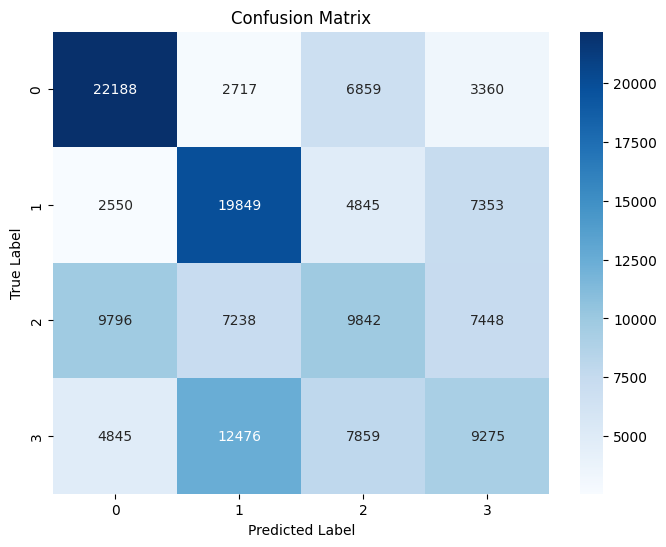

In [ ]:
report, cm = classifier.evaluate_model(test_pool)

print("\nReporte de Clasificación:")
print(report)
print("\nMatriz de Confusión:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Prueba con los datos de envío

In [ ]:
X_test = pd.read_csv('test.csv')

In [ ]:
# Hacer y guardar predicciones
results = classifier.save_predictions(X_test, 'my_submission.csv')

In [ ]:
results

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,medio-bajo
296782,209415,alto
296783,239074,medio-alto
296784,963852,alto


# Envío para la competencia en Kaggle

In [ ]:
!head my_submission.csv
!kaggle competitions submit -c udea-ai4eng-20242 -f my_submission.csv -m "version final del catboost"

ID,RENDIMIENTO_GLOBAL
550236,bajo
98545,medio-alto
499179,alto
782980,bajo
785185,bajo
58495,bajo
705444,alto
557548,alto
519909,bajo
100% 4.06M/4.06M [00:00<00:00, 5.80MB/s]
Successfully submitted to UDEA/ai4eng 20242 - Pruebas Saber Pro Colombia